In [244]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib

%matplotlib inline

sns.set_style('whitegrid')

# add time converter for matplotlib visualisation
pd.plotting.register_matplotlib_converters()

In [245]:
# The path to the raw crops and livestock dataset from FAO site (import/export data)
fao_path_normalized = '../data/fao/'

# Reading the dataset from csv file and leaving only needed columns
trading_data_normalized = pd.read_csv(fao_path_normalized + 'trading_data.csv', encoding='latin-1')
trading_data = trading_data_normalized[['Area', 'Item', 'Element', 'Year', 'Unit', 'Value']]

# Renaming columns
trading_data = trading_data.rename(columns={
    'Area': 'country',
    'Item': 'item',
    'Element': 'value_meaning',
    'Year': 'year',
    'Value': 'value',
    'Unit': 'unit'
})

# Convert the year to a datetime object
trading_data['year'] = pd.to_datetime(trading_data['year'], format='%Y')

# Leaving only the Import Quantity and the Export Quantity
trading_data = trading_data[(trading_data['value_meaning'] == 'Import Quantity') | (trading_data['value_meaning'] == 'Export Quantity')]

Let us get the list of countries in the `trading_data` dataframe.

In [246]:
trading_data['country'].unique()

array(['Afghanistan', 'Albania', 'Algeria', 'American Samoa', 'Angola',
       'Antigua and Barbuda', 'Argentina', 'Armenia', 'Aruba',
       'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain',
       'Bangladesh', 'Barbados', 'Belarus', 'Belgium',
       'Belgium-Luxembourg', 'Belize', 'Benin', 'Bermuda', 'Bhutan',
       'Bolivia (Plurinational State of)', 'Bosnia and Herzegovina',
       'Botswana', 'Brazil', 'British Virgin Islands',
       'Brunei Darussalam', 'Bulgaria', 'Burkina Faso', 'Burundi',
       'Cabo Verde', 'Cambodia', 'Cameroon', 'Canada', 'Cayman Islands',
       'Central African Republic', 'Chad', 'Chile', 'China',
       'China, Hong Kong SAR', 'China, Macao SAR', 'China, mainland',
       'China, Taiwan Province of', 'Colombia', 'Comoros', 'Congo',
       'Cook Islands', 'Costa Rica', "Côte d'Ivoire", 'Croatia', 'Cuba',
       'Cyprus', 'Czechia', 'Czechoslovakia',
       "Democratic People's Republic of Korea",
       'Democratic Republic of the Congo', '

We can see that in the end of this list we have rows indicating not the countries but the aggregated data (e.g. 'World', 'Africa', 'European Union trade', etc). Let us drop this columns.

In [247]:
list_of_aggregated_data_rows = ['World', 'Africa',
       'Eastern Africa', 'Middle Africa', 'Northern Africa',
       'Southern Africa', 'Western Africa', 'Americas',
       'Northern America', 'Central America', 'Caribbean',
       'South America', 'Asia', 'Central Asia', 'Eastern Asia',
       'Southern Asia', 'South-Eastern Asia', 'Western Asia', 'Europe',
       'Eastern Europe', 'Northern Europe', 'Southern Europe',
       'Western Europe', 'Oceania', 'Australia & New Zealand',
       'Melanesia', 'Micronesia', 'Polynesia', 'EU(12)ex.int',
       'EU(15)ex.int', 'EU(25)ex.int', 'EU(27)ex.int', 'European Union',
       'European Union (exc intra-trade)', 'Least Developed Countries',
       'Land Locked Developing Countries',
       'Small Island Developing States',
       'Low Income Food Deficit Countries',
       'Net Food Importing Developing Countries']

trading_data = trading_data.set_index('country').drop(index=list_of_aggregated_data_rows).reset_index()

Let us calculate the number of rows with NaN values.

In [248]:
print('The number of rows with NaN values is: %d' % trading_data[pd.isnull(trading_data).any(axis=1)].shape[0])

The number of rows with NaN values is: 1321355


We can see that we have a **huge** number of rows with NaN values. In scope of our project we treat these values as zero, because in most cases we will focus only on the major trading products when comparing different countries.

In [249]:
# Filling the NaN values with 0
trading_data.fillna(0, inplace=True)

Now we can separate the import data and the export data for future analysis.

In [250]:
# Creating additional dataframes for keeping import and export data
import_data = trading_data[trading_data['value_meaning'] == 'Import Quantity']
export_data = trading_data[trading_data['value_meaning'] == 'Export Quantity']

Let us see how many distinct trading products do we have in each dataset.

In [251]:
print('The number of distinct trading products in import dataset is: %d' % len(import_data['item'].unique()))
print('The number of distinct trading products in export dataset is: %d' % len(export_data['item'].unique()))

The number of distinct trading products in import dataset is: 452
The number of distinct trading products in export dataset is: 446


We can see that in our dataset we have a **huge** diversity of the trading products. It will be convenient to sort them by the average import and export value over the time period - in that case we will have the most important products with the biggest trading (import or export) value above. We will create two additional dataframes `import_data_sorted` and `export_data_sorted` which keeps the biggest trading (based on the average import/export value) products above.

In [252]:
# Create the dataframe which contains the biggest import products for each country
import_data_sorted = (import_data.groupby(['country', 'item'])
                           .mean()
                               .groupby(level='country', group_keys=False)
                                   .apply(lambda x: x.sort_values(by='value', ascending=False))
                                       .rename(columns={'value': 'average_import_value'})
                      )

# Create the dataframe which contains the biggest export products for each country
export_data_sorted = (export_data.groupby(['country', 'item'])
                           .mean()
                               .groupby(level='country', group_keys=False)
                                   .apply(lambda x: x.sort_values(by='value', ascending=False))
                                       .rename(columns={'value': 'average_export_value'})
                      )

In [253]:
# Show the country and the biggest import products in a nice way
import_data_sorted.groupby(level='country', group_keys=True).apply(lambda df: df.nlargest(n=3, columns='average_import_value')).head(20)

average_import_value
country             country             item                                              
Afghanistan         Afghanistan         Cereals                               5.898406e+05
                                        Wheat+Flour,Wheat Equivalent          5.210205e+05
                                        Sugar Raw Centrifugal                 2.988893e+05
Albania             Albania             Cereals                               2.358327e+05
                                        Wheat+Flour,Wheat Equivalent          1.977996e+05
                                        Wheat                                 1.473262e+05
Algeria             Algeria             Cereals                               5.005716e+06
                                        Wheat+Flour,Wheat Equivalent          3.571040e+06
                                        Wheat                                 3.093106e+06
American Samoa      American Samoa      Milk Equivalent                       3.368625e+03
                                        Total Meat                            2.858214e+03
                                        Cereals                               2.556804e+03
Angola              Angola              Cereals                               4.163060e+05
                                        Wheat+Flour,Wheat Equivalent          2.449849e+05
                                        Beverages                             1.509927e+05
Antigua and Barbuda Antigua and Barbuda Beverages                             5.920536e+03
                                        Cereals                               5.452268e+03
                                        Milk Equivalent                       5.032839e+03
Argentina           Argentina           Oilseeds                              2.167728e+05
                                        Bananas and plantains                 2.110490e+05

In [254]:
# Show the country and the biggest export products in a nice way
export_data_sorted.groupby(level='country', group_keys=True).apply(lambda df: df.nlargest(n=3, columns='average_export_value')).head(20)

average_export_value
country             country             item                                          
Afghanistan         Afghanistan         Raisins                           3.588202e+04
                                        Grapes                            3.018829e+04
                                        Vegetables, fresh nes             1.763130e+04
Albania             Albania             Vegetables, fresh nes             1.886545e+04
                                        Tomatoes                          1.068041e+04
                                        Beverages                         7.931393e+03
Algeria             Algeria             Beverages                         2.902509e+05
                                        Wine+Vermouth+Sim.                2.828663e+05
                                        Wine                              2.792099e+05
American Samoa      American Samoa      Pet food                          6.626418e+03
                                        Fodder & Feeding stuff            6.508786e+03
                                        Cotton lint                       1.574500e+03
Angola              Angola              Coffee Green+Roast                5.623784e+04
                                        Coffee, green                     5.623650e+04
                                        Cereals                           3.117533e+04
Antigua and Barbuda Antigua and Barbuda Sugar and Honey                   2.764107e+03
                                        Sugar,Total (Raw Equiv.)          2.327019e+03
                                        Sugar Raw Centrifugal             2.327019e+03
Argentina           Argentina           Cereals                           1.619998e+07
                                        Fodder & Feeding stuff            1.084092e+07

Let us plot the import and the export levels of Afghanistan during the period of observation.

In [255]:
# Calculating the summed import and export values for each country
import_summed_data = import_data.groupby(['country', 'year']).sum().rename(columns={'value': 'total_import_value'})
export_summed_data = export_data.groupby(['country', 'year']).sum().rename(columns={'value': 'total_export_value'})

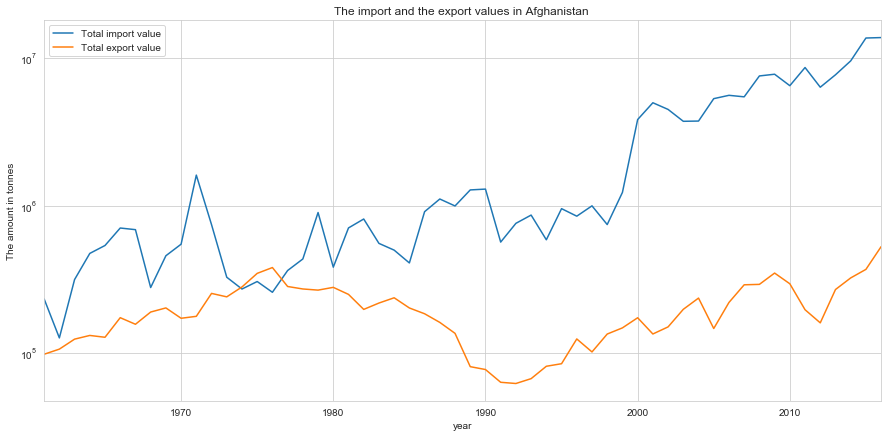

In [256]:
f, ax = plt.subplots(figsize=(15, 7))

import_summed_data.loc['Afghanistan'].plot.line(ax=ax, y='total_import_value', label='Total import value')
export_summed_data.loc['Afghanistan'].plot.line(ax=ax, y='total_export_value', label='Total export value')
ax.set_yscale('log')
ax.set_title('The import and the export values in Afghanistan ')
ax.set_ylabel('The amount in tonnes');